In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [79]:
sqrtns = [128, 192, 256, 320]
block_sizes = {128: [512, 256, 128],
             192: [512, 256, 128],
             256: [1024, 512, 256],
             320: [2048, 1024, 512]}
nts = np.arange(27, 0, -3)

data_size = (len(sqrtns), len(block_sizes), len(nts), 10)
ompfor_data_time = np.ones(data_size)*10000
batch_data_time = np.ones(data_size)*10000
with open("result2.txt", "r") as fd:
    all_lines = fd.readlines()
    for i in reversed(range(len(all_lines))):
        if all_lines[i][0] == '#':
            del all_lines[i]
    total_tests = len(all_lines)/18
    #print len(all_lines)/float(18)
    i2 = 0
    for i in range(18, len(all_lines)+1, 18):
        run_cmd = all_lines[i-18]
        ompfor_time = all_lines[i-16]
        ompfor_mem = all_lines[i-6]
        batch_time = all_lines[i-13]
        batch_mem = all_lines[i-3]
        #print run_cmd, ompfor, batch,
        sp = run_cmd.split()
        sqrtn, bs, nt = map(int, [sp[j] for j in [1, 2, 8]])
        #print rb, cb, bs, mr, nt, rb*cb
        sqrtn_index = sqrtns.index(sqrtn)
        bs_index = block_sizes[sqrtn].index(bs)
        nt_index = nt/3-1
        #print sqrtn_index, bs_index, nt_index, i2
        ompfor_data_time[sqrtn_index, bs_index, nt_index, i2] = float(ompfor_time.split()[-2])
        batch_data_time[sqrtn_index, bs_index, nt_index, i2] = float(batch_time.split()[-1])
        if i2 == 9:
            i2 = 0
        else:
            i2 += 1

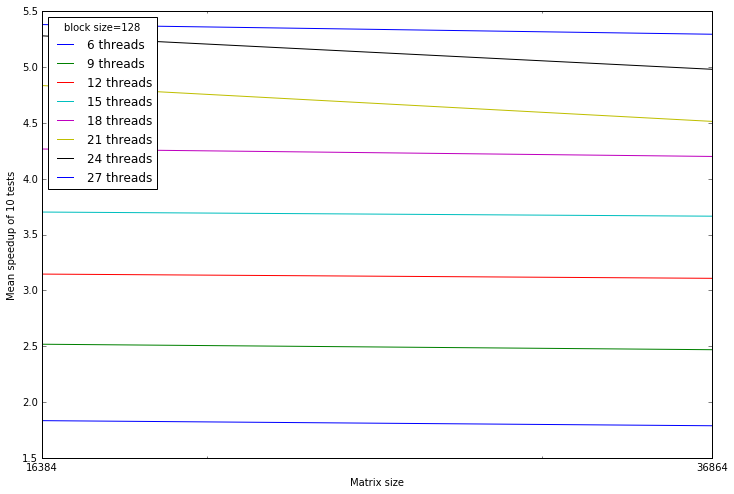

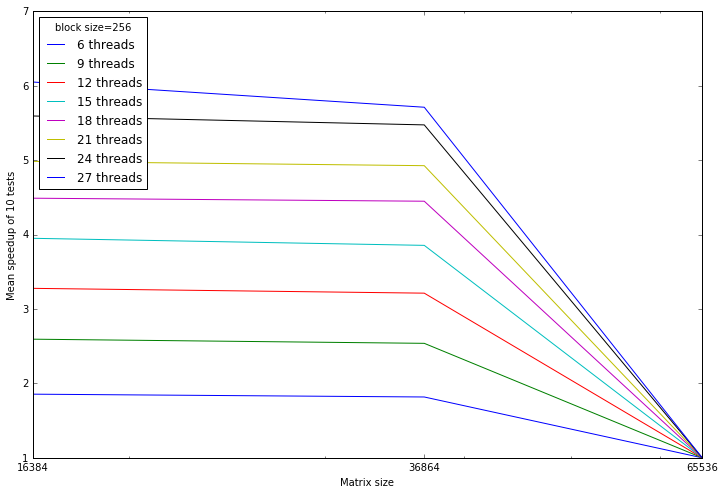

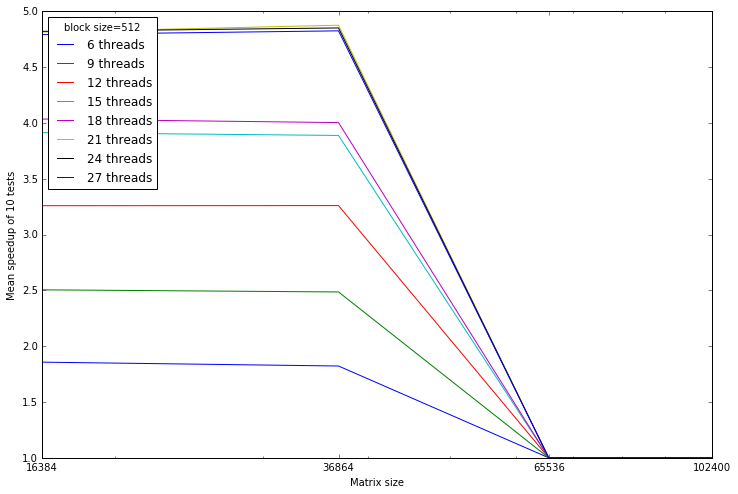

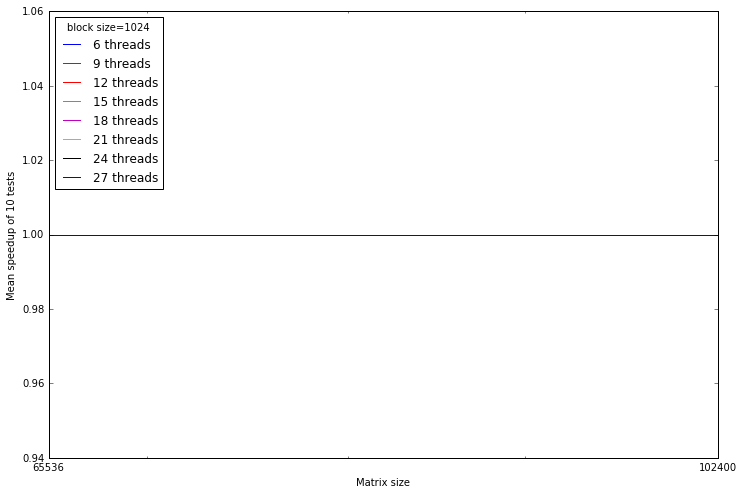

In [92]:
data = batch_data_time
ompfor_data = ompfor_data_time
#print data[1,2,0]
draw_data = np.array([[[[data[i, j, k].min(), data[i, j, k].mean(), data[i, j, k].max()]
                       for k in range(data_size[2])] for j in range(data_size[1])] for i in range(data_size[0])])
draw_ompfor_data = np.array([[[[ompfor_data[i, j, k].min(), ompfor_data[i, j, k].mean(), ompfor_data[i, j, k].max()]
                       for k in range(data_size[2])] for j in range(data_size[1])] for i in range(data_size[0])])

all_bs = [128, 256, 512, 1024]
for bs in all_bs:
    fig, ax = plt.subplots(figsize=(12,8))
    fixed_bs = [[] for i in range(data_size[2])]
    fixed_bs_index = []
    for i in range(0, data_size[0]):
        try:
            bs_index = block_sizes[sqrtns[i]].index(bs)
            fixed_bs_index.append(i)
            for j in range(1, data_size[2]):
                fixed_bs[i].append(draw_data[i,bs_index,0,1]/draw_data[i,bs_index,j,1])
        except:
            pass
    for i in reversed(range(len(fixed_bs))):
        if not fixed_bs[i]:
            del fixed_bs[i]
    fixed_bs = np.array(fixed_bs)
    size = np.array([sqrtns[i]**2 for i in fixed_bs_index])
    for i in range(fixed_bs.shape[1]):
        ax.semilogx(size, np.array(fixed_bs[:,i]), label="{} threads".format(3*i+6))
    ax.set_xticks(size)
    ax.set_xlim(size[0], size[-1])
    ax.set_xticklabels(size)
    ax.set_xlabel("Matrix size")
    ax.set_ylabel("Mean speedup of 10 tests")
    #ax.set_yticklabels(np.arange())
    ax.legend(title="block size={}".format(bs), loc=2)
    plt.savefig("batched_speedup_bs{}.pdf".format(bs))
    plt.show()
    plt.close()

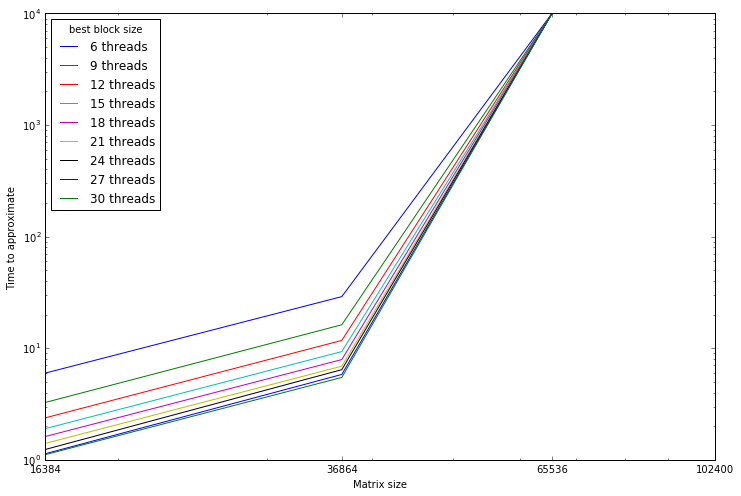

In [93]:
best_batch_performance = draw_data[:,:,:,1].min(axis=1)
best_ompfor_performance = draw_ompfor_data[:,:,:,1].min(axis=1)
#print best_performance.shape, draw_data.shape
fig, ax = plt.subplots(figsize=(12,8))
size = np.array(sqrtns)**2
for i in range(best_batch_performance.shape[1]):
    ax.loglog(size, best_batch_performance[:,i], label="{} threads".format(i*3+6))
ax.set_xticks(size)
ax.set_xlim(size[0], size[-1])
ax.set_xticklabels(size)
ax.set_xlabel("Matrix size")
ax.set_ylabel("Time to approximate")
ax.legend(title="best block size", loc=2)
plt.savefig("batched_time_for_best_block_size.pdf")

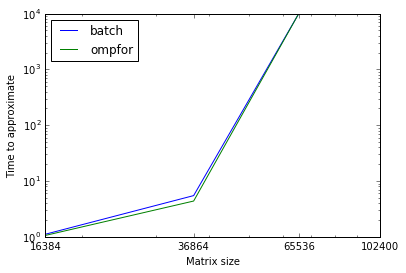

In [94]:
fig, ax = plt.subplots(figsize=(6,4))
ax.loglog(size, best_performance[:,-1], label="batch")
ax.loglog(size, best_ompfor_performance[:,-1], label="ompfor")
ax.set_xticks(size)
ax.set_xlim(size[0], size[-1])
ax.set_xticklabels(size)
ax.set_xlabel("Matrix size")
ax.set_ylabel("Time to approximate")
ax.legend(loc=2)
plt.savefig("batched_vs_ompfor_best_block_size.pdf")